# Trabajo Práctico N5. Restauracion de Imagenes

In [279]:
import numpy as np
from scipy import signal
import cv2
import matplotlib.pyplot as plt
from IPython.display import clear_output
from numpy.fft import fft2,fftshift,ifft2,ifftshift

In [280]:
#Funciones auxiliares

def myplotimg (img,vmin=0,vmax=255,title=None):
  plt.imshow(img,cmap='gray', vmin=vmin, vmax=vmax)
  if title != None:
    plt.title(title)
  plt.axis("off")
  plt.show()
  return

def show_side_by_side(imgs, subtitles = None, title = None, vmin=0, vmax=255, **kwargs):
    fig, axes = plt.subplots(1, len(imgs), **kwargs)
    if len(imgs) == 1:
        axes = [axes]
    if title is not None:
        fig.suptitle(title, y=0.8)
    if subtitles is None:
        subtitles = [None for _ in imgs]
    for ax, img, subtitle in zip(axes, imgs, subtitles):
        if subtitle is not None:
            ax.set_title(subtitle)
        ax.imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
        ax.axis('off')
        
    plt.tight_layout()
    plt.show()

In [281]:
#definimos la funcion del filtro: recibe el tamaño del kernel,
#y la imagen sobre la que se aplica el filtro, se usa filtro promediador
def ApplyBlur(img, kernel): #lowpass
  kernel = ExpandKernel(kernel, (img).shape)
  blur = fft2(img)*fft2(kernel)
  return np.real(fftshift(ifft2(blur)))

def ApplyNoise(img, std=1):
  row,col = img.shape
  mean = 0
  gauss = np.random.normal(mean,std,(row,col))
  gauss = gauss.reshape(row,col)
  noisy = img.astype(float) + gauss.astype(float)
  return noisy.astype(float)


def ExpandKernel(kernel, size):
  delta = np.zeros((size[0], size[1]), dtype=float)
  delta[size[0]//2,size[1]//2] = 1
  return cv2.filter2D(delta, -1, kernel)

#https://stackoverflow.com/questions/29731726/how-to-calculate-a-gaussian-kernel-matrix-efficiently-in-numpy
def gkern(kernlen=21, std=3):
  """Returns a 2D Gaussian kernel array."""
  gkern1d = signal.gaussian(kernlen, std=std).reshape(kernlen, 1)
  gkern2d = np.outer(gkern1d, gkern1d)
  gkern2d /= np.sum(gkern2d)
  return gkern2d


def ApplyInverseFilter(degraded_og, kernel):
  degraded = degraded_og.copy()
  kernel = ExpandKernel(kernel, (degraded).shape)
  #Kernel Spectrum
  H = fft2(kernel) 
  #Degraded image spectrum
  G = fft2(degraded)
  # Inverse Filter 
  F_hat = fftshift(G/(H))
  restored = np.real(fftshift(ifft2(ifftshift(F_hat))))
  return restored


In [282]:
def mse(img1, original):
  return np.mean((img1-original)**2)
  

## 1. Inverse Filter

### a. Blur

C:\Users\Santiago\AppData\Local\Temp\ipykernel_16048\269251678.py:25: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  gkern1d = signal.gaussian(kernlen, std=std).reshape(kernlen, 1)


MSE entre imagen original y la imagen con blur es: 61.62861392087558
MSE entre imagen original y la restaurada es: 9.879287759930215e-19


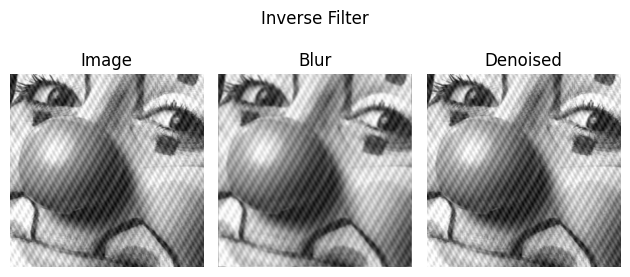

In [283]:
#imagen original
#Imagenes de opcion: clown.jpg , lenna.jpg , stream_and_bridge.tiff
img = cv2.imread("clown.jpg", cv2.IMREAD_GRAYSCALE)

#kernel = np.full((3, 3), 1)/(3**2)
kernel = gkern(kernlen=3, std=20)

degraded = ApplyBlur(img, kernel)
blurred = degraded.copy()
restored = ApplyInverseFilter(degraded, kernel)

print('MSE entre imagen original y la imagen con blur es:', mse(blurred, img))
print('MSE entre imagen original y la restaurada es:', mse(restored, img))


show_side_by_side([img, degraded, restored], ["Image", "Blur", "Denoised"], "Inverse Filter")

Se obtiene un muy bajo error usando Inverse filter en el caso de blur.
Ahora, agregaremos la degradación por ruido aditivo.
### b. Blur + Noise

C:\Users\Santiago\AppData\Local\Temp\ipykernel_16048\269251678.py:25: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  gkern1d = signal.gaussian(kernlen, std=std).reshape(kernlen, 1)


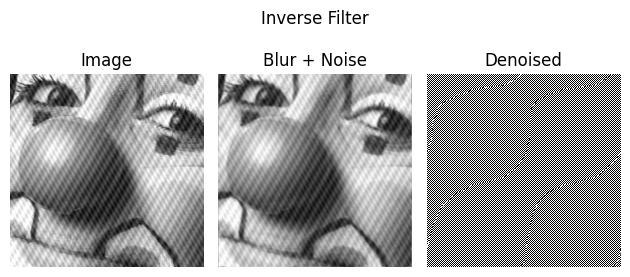

MSE entre imagen original y la imagen con blur+noise es: 65.67748439986333
MSE entre imagen original y la restaurada es: 5753236821.709935


In [284]:
#Original
blur_noisy = ApplyNoise(blurred,std=2)
kernel = gkern(kernlen=3, std=20)
restored_noisy = ApplyInverseFilter(blur_noisy, kernel)
show_side_by_side([img, blur_noisy, restored_noisy], ["Image", "Blur + Noise", "Denoised"], "Inverse Filter")

print('MSE entre imagen original y la imagen con blur+noise es:', mse(blur_noisy, img))
print('MSE entre imagen original y la restaurada es:', mse(restored_noisy, img))

Notamos que cuando se agrega el ruido a la ecuación, el filtrado inverso no resulta apto para la reconstrucción.

## Filtro por Wiener
Se nota a partir de los resultados del filtrado inverso de la imagen degradada, además de por la distorsion del sistema óptico, por ruido normal aditivo, que este método no resulta aplicable para estos casos. Es por ello que en estos casos un tipo de filtro común es el que se deduce de plantear el problema como la solución optima lineal que minimiza cierto criterio de error, como lo es el del error cuadrático medio (MSE). 

In [285]:
def WienerRestore(kernel,degraded_img,noise_std=None,original_img=None):
  expanded_kernel = ExpandKernel(kernel, degraded_img.shape)
  H = np.fft.fft2( np.fft.ifftshift(expanded_kernel) )
  H_power = np.power(abs(H), 2* np.ones(H.shape))
  L= 1e-1
  if (noise_std == None):
    W = np.conjugate(H) / (H_power + L)
  else:
    img_mod = abs( np.fft.fft2( original_img ) )
    Sxx = np.power( img_mod, 2* np.ones(img_mod.shape)) / (img_mod.shape[0] * img_mod.shape[1])
    Snn = (noise_std*noise_std) * np.ones( Sxx.shape ) 
    W = np.conjugate(H) / (H_power + (Snn/Sxx) ) 
  F_hat = np.fft.fft2( degraded_img ) * W
  aux = np.nan_to_num(F_hat)
  restored = abs( np.fft.ifft2( aux )  ) 
  restored[restored < 0] = 0
  restored[restored > 255] = 255
  return restored.astype(int)

<Figure size 1500x1500 with 0 Axes>

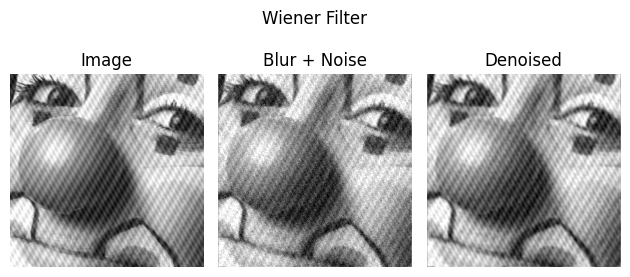

MSE entre imagen original y la imagen con blur+noise es: 458.13017896574695
MSE entre imagen original y la restaurada es: 87.19752186588921


In [286]:
#Original
std_ = 20
blur_noisy = ApplyNoise(degraded,std=std_)
restored_noisy = WienerRestore(kernel.astype(float),blur_noisy.astype(float),noise_std=std_,original_img=img.astype(float))

fig_a = plt.figure(figsize=(15,15))
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0.2, wspace = 0.2)


show_side_by_side([img, blur_noisy, restored_noisy], ["Image", "Blur + Noise", "Denoised"], "Wiener Filter")
print('MSE entre imagen original y la imagen con blur+noise es:', mse(blur_noisy, img))
print('MSE entre imagen original y la restaurada es:', mse(restored_noisy, img))

### 3-Blind Deconvolution
Generalmente en la práctica, no contamos con la PSF de la imagen original sin distorsión. Es por eso, que se desarrollaron algoritmos iterativos para, justamente, aproximar la misma para realizar el filtrado. La idea que engloba a este tratamiento de las señales es la de "Blind Deconvolution" (si antes deconvolucionabamos con la PSF conocida, ahora no la conocemos, por eso "ciega").
Para Blind Deconvolution se utilizó el algoritmo de Richardson-Lucy del paquete skimage. Recibe como argumento la imagen desenfocada, es decir la imagen a restaurar y una estimación inicial de la PSF (point spread function). Consideramos como estimación una matriz de 9x9 normalizada.
La imagen restaurada gana enfoque mediante las iteraciones de la función.



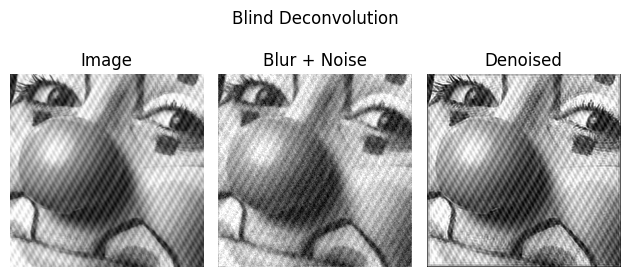

MSE entre imagen original y la imagen con blur+noise es: 458.13017896574695
MSE entre imagen original y la restaurada es: 718.2768268909091


In [287]:
from skimage import restoration

bdeconv_orig=img.copy()

n = 3
m = 3
psf = np.ones((n, m)) / (n*m)
# Restore Image using Richardson-Lucy algorithm
restored = restoration.richardson_lucy(bdeconv_orig/255, psf, num_iter=15)
restored *= 255                         #Desnormalizamos la imagen

show_side_by_side([img, blur_noisy, restored], ["Image", "Blur + Noise", "Denoised"], "Blind Deconvolution")
print('MSE entre imagen original y la imagen con blur+noise es:', mse(blur_noisy, img))
print('MSE entre imagen original y la restaurada es:', mse(restored, img))

Si bien notamos que el MSE de la imagen restaurada no es mejor que la imagen con distorsion, en lo que se refiere a percepcion notamos que se obtienen muy buenos resultados en el centro de la imagen. El alto valor del MSE por tanto, podemos inferir que se debe a los artefactos introducidos en los bordes de la imagen, que inferimos tambien tiene que ver con la aproximacion que se realiza al plantear las hipotesis de este algoritmo.

## 4- Motion Blur
En este caso, en primer lugar se simula un motion blur, también conocido como desenfoque por movimiento, que es un desenfoque que sigue el movimiento del objeto o de la cámara. Y a continuación se busca eliminar esta degradación utilizando el Filtro de Weiner previamente desarrollado.


In [288]:

#Distorsiona la imagen mediante un blur equivalente al movimiento del sensor.
def motion_blured(img,kSize=30,mode="vertical"):
# "The greater the size, the more the motion."
  kernel_size = kSize
  kernel = np.zeros((kernel_size, kernel_size))
  if mode=="vertical":
    kernel[:, int((kernel_size - 1)/2)] = np.ones(kernel_size)
  else:
    kernel[int((kernel_size - 1)/2), :] = np.ones(kernel_size)
  kernel /= kernel_size
  blurred_img = cv2.filter2D(img, -1, kernel)
  return blurred_img, kernel


C:\Users\Santiago\AppData\Local\Temp\ipykernel_16048\269251678.py:25: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  gkern1d = signal.gaussian(kernlen, std=std).reshape(kernlen, 1)


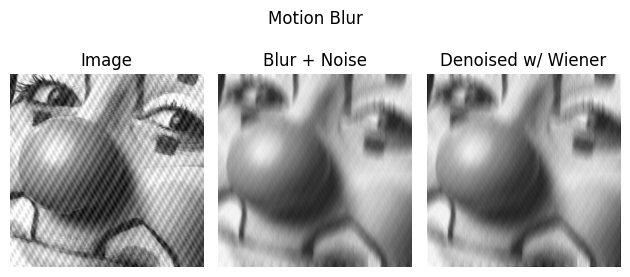

MSE entre imagen original y la imagen con motion blur es: 89.22842334212596
MSE entre imagen original y la restaurada es: 560.6318779212365


In [289]:


#aplico motion blur
degraded , _ = motion_blured(img,kSize=21,mode="vertical")


restored = WienerRestore(gkern(kernlen=3, std=0.5), degraded.astype(float), noise_std=0.5, original_img=img.astype(float))


show_side_by_side([img, degraded, restored], ["Image", "Blur + Noise", "Denoised w/ Wiener"], "Motion Blur")
print('MSE entre imagen original y la imagen con motion blur es:', mse(degraded, img))
print('MSE entre imagen original y la restaurada es:', mse(restored, img))

## Metodos de regularizacion
#### Regularizacion determinística


In [290]:
def DeterministicRegularization(img,H,alpha,d_kernel=None):
  if d_kernel == None:
    C_mat = np.array( [
                       [0,-0.25,0],
                      [-0.25,-1,-0.25],
                        [0,-0.25,0]
                      ])
  else:
    C_mat = d_kernel
  aux_kernel = np.matmul(H,np.transpose(H)) + alpha* np.matmul( np.transpose(C_mat),C_mat )
  new_kernel = np.matmul(aux_kernel, np.transpose(H))
  return cv2.filter2D(img.astype(float), -1, new_kernel)

C:\Users\Santiago\AppData\Local\Temp\ipykernel_16048\269251678.py:25: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  gkern1d = signal.gaussian(kernlen, std=std).reshape(kernlen, 1)


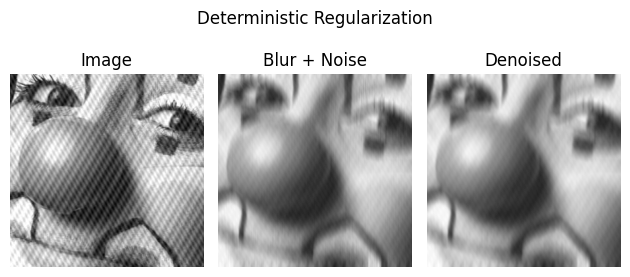

MSE entre imagen original y la imagen con blur + ruido blanco aditivo es: 89.22842334212596
MSE entre imagen original y la restaurada es: 9.607267854797286


In [291]:
#Definimos hiperparámetro alfa
alpha=0.95
# Aplicar el filtro de el algoritmo a la imagen
regularizationImage = DeterministicRegularization(degraded,gkern(kernlen=3, std=1),alpha)


show_side_by_side([img, degraded, regularizationImage], ["Image", "Blur + Noise", "Denoised"], "Deterministic Regularization")
print('MSE entre imagen original y la imagen con blur + ruido blanco aditivo es:', mse(degraded, img))
print('MSE entre imagen original y la restaurada es:', mse(degraded, regularizationImage))

Se nmota una mejora cuantitativa en el MSE, aunque el blur sigue siendo notorio.

### Metodo iterativo

In [292]:
def IterativeRegularization(img,H,alpha,iterations=2,d_kernel=None):
  if d_kernel == None:
    C_mat = np.array( [
                       [0,-0.25,0],
                      [-0.25,-1,-0.25],
                        [0,-0.25,0]
                      ])
  else:
    C_mat = d_kernel
  aux_kernel = np.matmul(H,np.transpose(H)) + alpha* np.matmul( np.transpose(C_mat),C_mat )
  hy= cv2.filter2D(img.astype(float), -1, np.transpose(H))
  eig, _ = np.linalg.eig(aux_kernel)
  max_eig = eig.max()
  beta = (1 / max_eig)
  last_f = beta * hy
  for i in range(0,iterations):
    last_f = last_f + beta*( hy - cv2.filter2D(last_f.astype(float), -1, aux_kernel) )
  return last_f

C:\Users\Santiago\AppData\Local\Temp\ipykernel_16048\269251678.py:25: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  gkern1d = signal.gaussian(kernlen, std=std).reshape(kernlen, 1)


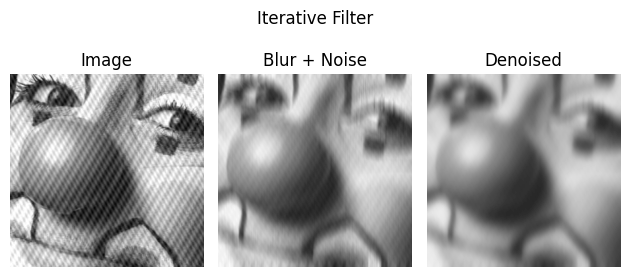

MSE entre imagen original y la imagen con blur + ruido blanco aditivo es: 89.22842334212596
MSE entre imagen original y la restaurada es: 69.88150271650912


In [293]:
alpha=1.3
iterativeImage = IterativeRegularization(degraded,gkern( 3, 2),alpha, iterations=30)
show_side_by_side([img, degraded, iterativeImage], ["Image", "Blur + Noise", "Denoised"], "Iterative Filter")
print('MSE entre imagen original y la imagen con blur + ruido blanco aditivo es:', mse(degraded, img))
print('MSE entre imagen original y la restaurada es:', mse(degraded, iterativeImage))

Si bien el filtrado no es obtimo, logra remover el detalle en altas frecuencias del ruido de interferencia,